=== IFFLP Simulation (STRONG Saturation) ===
Simulating to initial equilibrium (I = 1.5)...
Initial equilibrium: A=0.6846, B=0.7478, C=0.6498

Saturation check:
  (1-B) = 0.2522 vs KAB = 0.0010
  Ratio (1-B)/KAB = 252.2 (should be >> 1, say >10)
  B = 0.7478 vs KFBB = 10.0000
  Ratio B/KFBB = 0.0748 (should be << 1, say <0.1)

Perturbing to I' = 0.5...
New equilibrium:     A=0.3113, B=0.3276, C=0.6618

Changes:
  ΔA = -0.3733
  ΔB = -0.4203
  ΔC = +0.0121

Ratio R = B/A:
  Initial: 1.092293
  After perturbation: 1.052268
  Theoretical (saturation): 1.020408
  Change: 0.04002502 (should be ≈ 0)

Saved: ifflp_perturbation.png


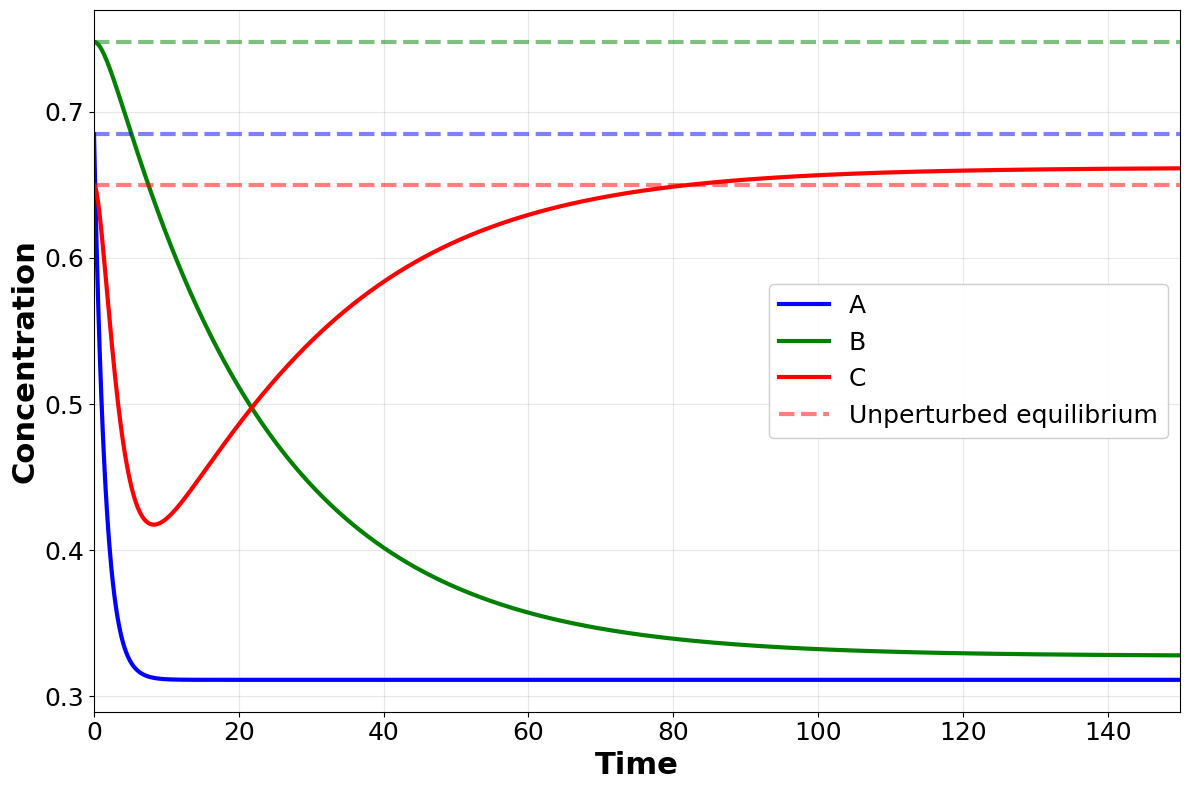

In [13]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# ============================================================================
# IFFLP MODEL with STRONG saturation parameters
# ============================================================================

def ifflp_odes_full(t, y, I, params):
    """
    Full IFFLP dynamics
    y = [A, B, C]
    """
    A, B, C = y
    
    # Unpack parameters
    kIA, KIA, FA, kFAA, KFAA = params['A']
    kAB, KAB, FB, kFBB, KFBB = params['B']
    kAC, KAC, kBC, KBC = params['C']
    
    # A dynamics
    dA_dt = (I * kIA * (1 - A) / (KIA + (1 - A)) - 
             FA * kFAA * A / (KFAA + A))
    
    # B dynamics
    dB_dt = (A * kAB * (1 - B) / (KAB + (1 - B)) - 
             FB * kFBB * B / (KFBB + B))
    
    # C dynamics
    dC_dt = (A * kAC * (1 - C) / (KAC + (1 - C)) - 
             B * kBC * C / (KBC + C))
    
    return [dA_dt, dB_dt, dC_dt]

# Parameters for STRONG saturation:
# Target: B ≈ 0.5, A ≈ 0.5
# At equilibrium under saturation: B = A * kAB * KFBB / (FB * kFBB)
# Want R = B/A ≈ 1, so: kAB * KFBB / (FB * kFBB) ≈ 1
# With KFBB = 10, FB = 0.7, kFBB = 0.7: need kAB ≈ 0.049
params = {
    'A': (1.0, 1.0, 1.1, 0.9, 1.2),         # kIA, KIA, FA, kFAA, KFAA
    'B': (0.05, 0.001, 0.7, 0.7, 10.0),     # kAB, KAB (tiny!), FB, kFBB, KFBB (large!)
    'C': (2.1, 1.5, 0.7, 0.6)               # kAC, KAC, kBC, KBC
}

# Initial conditions
A0, B0, C0 = 0.3, 0.4, 0.3
I_initial = 1.5

print("=== IFFLP Simulation (STRONG Saturation) ===")
print(f"Simulating to initial equilibrium (I = {I_initial})...")

# Step 1: Reach initial equilibrium
t_span = [0, 200]
t_eval = np.linspace(0, 200, 1000)
y0 = [A0, B0, C0]

sol_initial = solve_ivp(
    lambda t, y: ifflp_odes_full(t, y, I_initial, params),
    t_span, y0, t_eval=t_eval, method='LSODA', rtol=1e-8, atol=1e-10
)

A_eq, B_eq, C_eq = sol_initial.y[:, -1]
print(f"Initial equilibrium: A={A_eq:.4f}, B={B_eq:.4f}, C={C_eq:.4f}")

# Verify saturation conditions
print(f"\nSaturation check:")
print(f"  (1-B) = {1-B_eq:.4f} vs KAB = {params['B'][1]:.4f}")
print(f"  Ratio (1-B)/KAB = {(1-B_eq)/params['B'][1]:.1f} (should be >> 1, say >10)")
print(f"  B = {B_eq:.4f} vs KFBB = {params['B'][4]:.4f}")
print(f"  Ratio B/KFBB = {B_eq/params['B'][4]:.4f} (should be << 1, say <0.1)")

# Step 2: Perturb input I
I_perturbed = 0.5
print(f"\nPerturbing to I' = {I_perturbed}...")

t_span_perturb = [0, 800]
t_eval_perturb = np.linspace(0, 800, 8000)
y0_perturb = [A_eq, B_eq, C_eq]

sol_perturb = solve_ivp(
    lambda t, y: ifflp_odes_full(t, y, I_perturbed, params),
    t_span_perturb, y0_perturb, t_eval=t_eval_perturb,
    method='LSODA', rtol=1e-8, atol=1e-10
)

A_new, B_new, C_new = sol_perturb.y[:, -1]
print(f"New equilibrium:     A={A_new:.4f}, B={B_new:.4f}, C={C_new:.4f}")
print(f"\nChanges:")
print(f"  ΔA = {A_new - A_eq:+.4f}")
print(f"  ΔB = {B_new - B_eq:+.4f}")
print(f"  ΔC = {C_new - C_eq:+.4f}")

# Check ratio R = B/A (this should be constant!)
R_initial = B_eq / A_eq
R_new = B_new / A_new
R_theory = params['B'][0] * params['B'][4] / (params['B'][2] * params['B'][3])
print(f"\nRatio R = B/A:")
print(f"  Initial: {R_initial:.6f}")
print(f"  After perturbation: {R_new:.6f}")
print(f"  Theoretical (saturation): {R_theory:.6f}")
print(f"  Change: {abs(R_new - R_initial):.8f} (should be ≈ 0)")

# Plot
fig1, ax = plt.subplots(figsize=(12, 8))

ax.plot(sol_perturb.t, sol_perturb.y[0], 'b-', linewidth=3, label='A')
ax.plot(sol_perturb.t, sol_perturb.y[1], 'g-', linewidth=3, label='B')
ax.plot(sol_perturb.t, sol_perturb.y[2], 'r-', linewidth=3, label='C')

ax.axhline(A_eq, color='b', linestyle='--', alpha=0.5, linewidth=3)
ax.axhline(B_eq, color='g', linestyle='--', alpha=0.5, linewidth=3)
ax.axhline(C_eq, color='r', linestyle='--', alpha=0.5, linewidth=3, 
           label='Unperturbed equilibrium')

ax.set_xlabel('Time', fontsize=22, fontweight='bold')
ax.set_ylabel('Concentration', fontsize=22, fontweight='bold')
ax.tick_params(axis='both', which='major', labelsize=18)
ax.legend(loc='best', fontsize=18, framealpha=0.95)
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 150)

plt.tight_layout()
plt.savefig('ifflp_perturbation.png', dpi=300, bbox_inches='tight')
print("\nSaved: ifflp_perturbation.png")
plt.show()

Saved: ifflp_coa.png
Saved: ifflp_pcoa.png


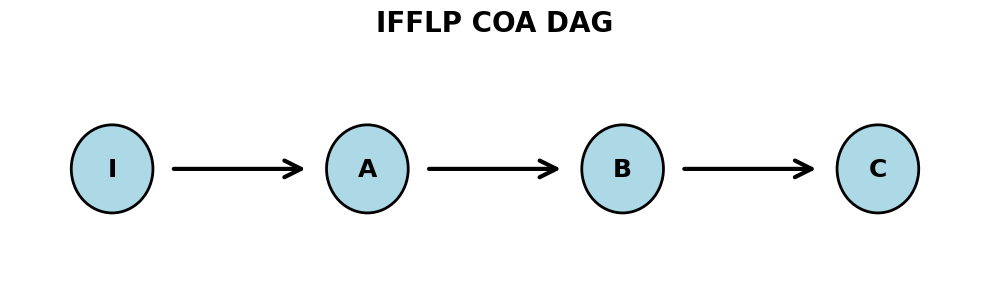

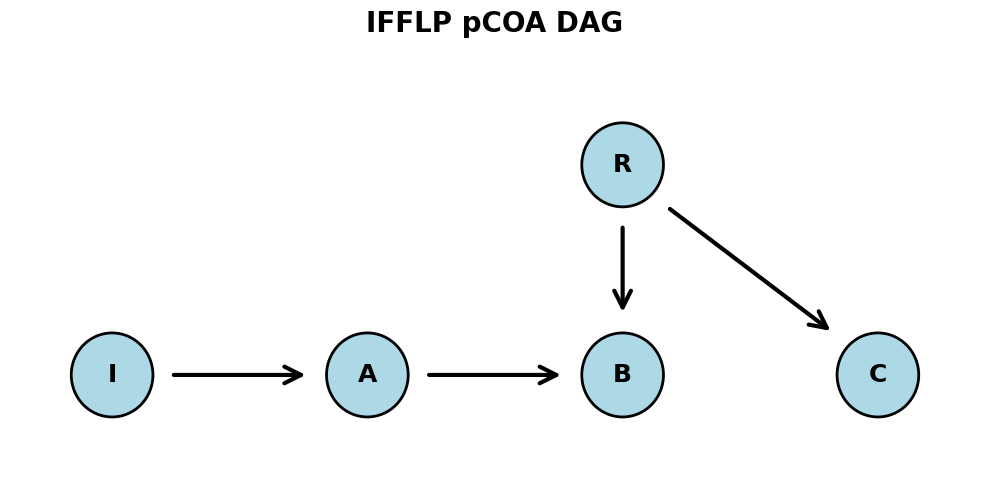


=== Summary ===
Full system simulation (no artificial saturation)
Perturbation: I reduced from 1.5 to 0.5

COA DAG: I → A → B → C
pCOA DAG: I → A → B ← R → C


In [14]:

# ============================================================================
# FIGURE 2: COA DAG (I → A → B → C)
# ============================================================================

fig2, ax = plt.subplots(figsize=(10, 3))

# Position nodes horizontally
pos_coa = {'I': (0, 0), 'A': (2.5, 0), 'B': (5, 0), 'C': (7.5, 0)}

# Draw nodes
for node in pos_coa:
    circle = plt.Circle(pos_coa[node], 0.4, color='lightblue', ec='black', linewidth=2, zorder=2)
    ax.add_patch(circle)
    ax.text(pos_coa[node][0], pos_coa[node][1], node, 
            fontsize=18, fontweight='bold', ha='center', va='center', zorder=3)

# Draw directed edges with proper arrowheads
arrow_props = dict(arrowstyle='->', lw=3, color='black', 
                   mutation_scale=30, shrinkA=15, shrinkB=15)

ax.annotate('', xy=(pos_coa['A'][0]-0.4, 0), xytext=(pos_coa['I'][0]+0.4, 0),
            arrowprops=arrow_props)
ax.annotate('', xy=(pos_coa['B'][0]-0.4, 0), xytext=(pos_coa['A'][0]+0.4, 0),
            arrowprops=arrow_props)
ax.annotate('', xy=(pos_coa['C'][0]-0.4, 0), xytext=(pos_coa['B'][0]+0.4, 0),
            arrowprops=arrow_props)

ax.set_xlim(-1, 8.5)
ax.set_ylim(-1, 1)
ax.axis('off')
ax.set_title('IFFLP COA DAG', fontsize=20, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('ifflp_coa.png', dpi=300, bbox_inches='tight')
print("Saved: ifflp_coa.png")

# ============================================================================
# FIGURE 3: pCOA DAG (I → A → B ← R → C)
# ============================================================================

fig3, ax = plt.subplots(figsize=(10, 5))

# Position nodes
pos_pcoa = {
    'I': (0, 0),
    'A': (2.5, 0),
    'B': (5, 0),
    'R': (5, 2),
    'C': (7.5, 0)
}

# Draw nodes
for node in pos_pcoa:
    circle = plt.Circle(pos_pcoa[node], 0.4, color='lightblue', ec='black', linewidth=2, zorder=2)
    ax.add_patch(circle)
    ax.text(pos_pcoa[node][0], pos_pcoa[node][1], node, 
            fontsize=18, fontweight='bold', ha='center', va='center', zorder=3)

# Draw directed edges
arrow_props = dict(arrowstyle='->', lw=3, color='black', 
                   mutation_scale=30, shrinkA=15, shrinkB=15)

# I → A
ax.annotate('', xy=(pos_pcoa['A'][0]-0.4, 0), xytext=(pos_pcoa['I'][0]+0.4, 0),
            arrowprops=arrow_props)

# A → B
ax.annotate('', xy=(pos_pcoa['B'][0]-0.4, 0), xytext=(pos_pcoa['A'][0]+0.4, 0),
            arrowprops=arrow_props)

# R → B (coming down from above)
ax.annotate('', xy=(pos_pcoa['B'][0], 0.4), xytext=(pos_pcoa['R'][0], 1.6),
            arrowprops=arrow_props)

# R → C
ax.annotate('', xy=(pos_pcoa['C'][0]-0.3, 0.3), xytext=(pos_pcoa['R'][0]+0.3, 1.7),
            arrowprops=arrow_props)

ax.set_xlim(-1, 8.5)
ax.set_ylim(-1, 3)
ax.axis('off')
ax.set_title('IFFLP pCOA DAG', fontsize=20, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('ifflp_pcoa.png', dpi=300, bbox_inches='tight')
print("Saved: ifflp_pcoa.png")

plt.show()

print("\n=== Summary ===")
print("Full system simulation (no artificial saturation)")
print(f"Perturbation: I reduced from {I_initial} to {I_perturbed}")
print("\nCOA DAG: I → A → B → C")
print("pCOA DAG: I → A → B ← R → C")